In [1]:
!git clone https://github.com/bryandlee/stylegan2-encoder-pytorch.git

Cloning into 'stylegan2-encoder-pytorch'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 97 (delta 36), reused 67 (delta 17), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [2]:
!nvidia-smi

Sat Feb  6 13:29:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd stylegan2-encoder-pytorch

/content/stylegan2-encoder-pytorch


In [4]:
!pip install ninja

     |████████████████████████████████| 112kB 9.1MB/s 


In [5]:
!mkdir 'checkpoint'

In [6]:
#Generator Drive Link

In [7]:
!cp '/content/drive/MyDrive/ML Models/idinvert-replicate-pytorch/generator_ffhq.pt' 'checkpoint/generator_ffhq.pt'

In [8]:
!cp '/content/drive/MyDrive/ML Models/idinvert-replicate-pytorch/encoder_ffhq.pt' 'checkpoint/encoder_ffhq.pt'

[generator loaded]
[encoder loaded]
generated samples:


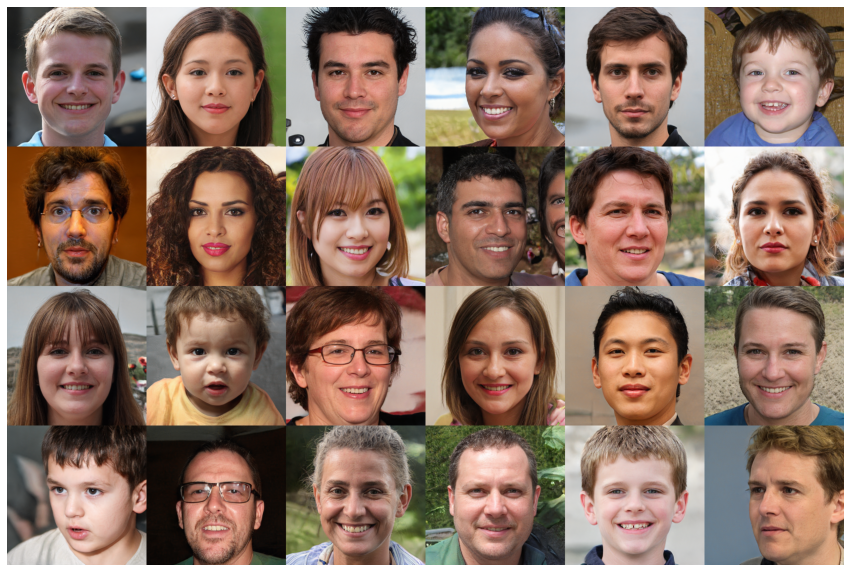

In [9]:
import os
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from model import Generator, Encoder
from train_encoder import VGGLoss

import matplotlib.pyplot as plt


def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()


device = 'cuda'
image_size=256

g_model_path = 'checkpoint/generator_ffhq.pt'
g_ckpt = torch.load(g_model_path, map_location=device)

latent_dim = g_ckpt['args'].latent

generator = Generator(image_size, latent_dim, 8).to(device)
generator.load_state_dict(g_ckpt["g_ema"], strict=False)
generator.eval()
print('[generator loaded]')

e_model_path = 'checkpoint/encoder_ffhq.pt'
e_ckpt = torch.load(e_model_path, map_location=device)

encoder = Encoder(image_size, latent_dim).to(device)
encoder.load_state_dict(e_ckpt['e'])
encoder.eval()
print('[encoder loaded]')

truncation = 0.7
trunc = generator.mean_latent(4096).detach().clone()

with torch.no_grad():
    latent = generator.get_latent(torch.randn(4*6, latent_dim, device=device))
    imgs_gen, _ = generator([latent],
                              truncation=truncation,
                              truncation_latent=trunc,
                              input_is_latent=True,
                              randomize_noise=True)

    result = []
    for row in imgs_gen.chunk(4, dim=0):
        result.append(torch.cat([img for img in row], dim=2))
    result = torch.cat(result, dim=1)
    print('generated samples:')
    imshow(tensor2image(result), size=15)

In [10]:
#Encoder Prediction

initial projections:


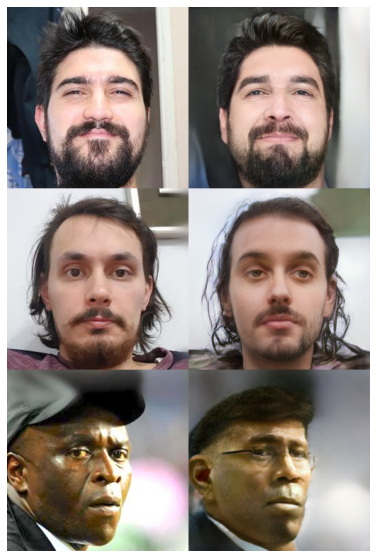

In [21]:
batch_size = 3

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='/content/stylegan2-encoder-pytorch/example_upper', transform=transform)
loader = iter(torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True))

imgs, _ = next(loader)
imgs = imgs.to(device)

with torch.no_grad():
    z0 = encoder(imgs)
    imgs_gen, _ =  generator([z0], 
                           input_is_latent=True,
                           truncation=truncation,
                           truncation_latent=trunc,
                           randomize_noise=False)

imgs_real = torch.cat([img for img in imgs], dim=1)
imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)

print('initial projections:')
imshow(tensor2image(torch.cat([imgs_real, imgs_fakes], dim=2)),10)

torch.Size([3, 14, 512])
step:10, loss:2.744053840637207


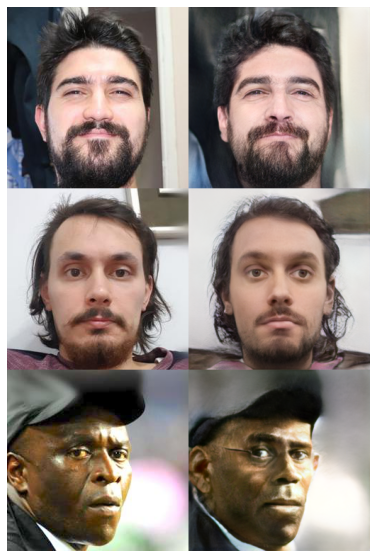

step:20, loss:2.447127103805542


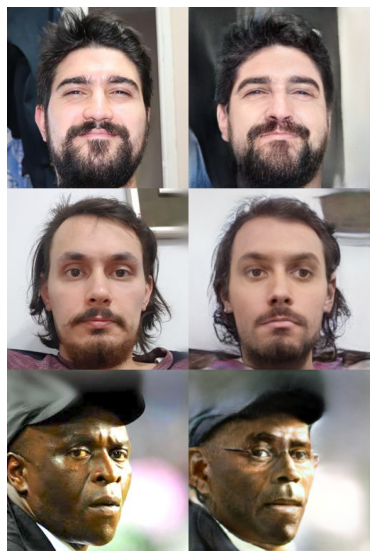

step:30, loss:2.2787182331085205


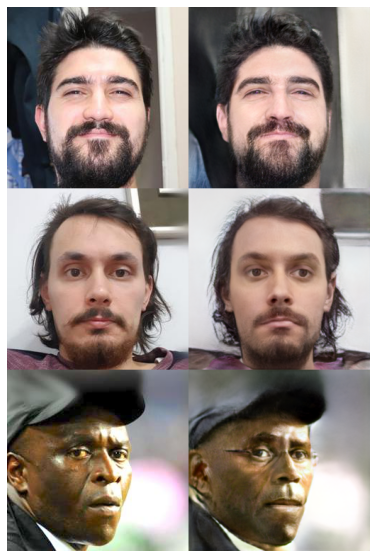

step:40, loss:2.145970582962036


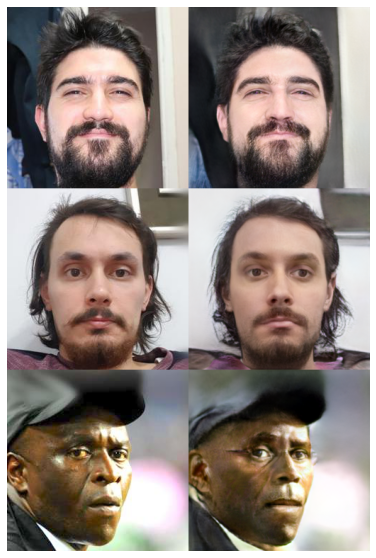

step:50, loss:2.054525136947632


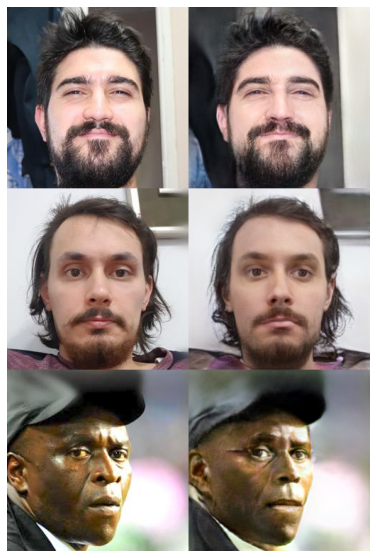

Elapsed: 24.093889713287354


In [22]:
import time

vgg_loss = VGGLoss(device)

z = z0.detach().clone()
print(z.shape)

z.requires_grad = True
optimizer = torch.optim.Adam([z], lr=0.05)

t1 = time.time()
for step in range(50):
    imgs_gen, _ = generator([z], 
                           input_is_latent=True, 
                           truncation=truncation,
                           truncation_latent=trunc, 
                           randomize_noise=False)

    z_hat = encoder(imgs_gen)
    
    loss = F.mse_loss(imgs_gen, imgs) + vgg_loss(imgs_gen, imgs) + F.mse_loss(z0, z_hat)*2.0 
    #loss = F.mse_loss(z0, z_hat)*2.0 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
    
    if (step+1)%10 == 0:
        print(f'step:{step+1}, loss:{loss.item()}')
        imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)        
        imshow(tensor2image(torch.cat([imgs_real, imgs_fakes], dim=2)),10)
    
    
    

t2 = time.time()
print("Elapsed: " + str(t2 -t1))
#F.mse_loss(imgs_gen, imgs): 6.59
#vgg_loss(imgs_gen, imgs): 8.27
#F.mse_loss(z0, z_hat): 8.44
#All: 10.18